In [1]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Load the data
data = pd.read_csv('Avg_values.csv')

In [2]:
data = data[['Lat','Lon','Predictions','Total']]

In [3]:
data

,Lat,Lon,Predictions,Total
0,39.22,-69.70,13.073122,4.046324
1,39.22,-69.65,13.053430,4.029126
2,39.23,-69.79,13.109862,4.085629
3,39.23,-69.75,13.091403,4.062843
4,39.24,-69.93,13.136818,4.134850
...,...,...,...,...
33484,46.15,-77.96,8.496900,1.643137
33485,46.15,-77.91,8.535372,1.646677
33486,46.15,-77.85,8.566020,1.651643
33487,46.15,-77.80,8.595417,1.655218


In [4]:
# Extract relevant columns for nearest neighbor search
coords = data[['Lat', 'Lon']].values
tree = cKDTree(coords)

# Function to compute spatial gradients
def compute_spatial_gradient(row, feature):
    # Get the coordinates of the current row
    current_coord = np.array([row['Lat'], row['Lon']])
    
    # Find the 4 nearest neighbors (excluding the point itself)
    distances, indices = tree.query(current_coord, k=5)  # Includes the point itself at index 0
    
    # Get the coordinates and feature values of the nearest neighbors
    neighbors = data.iloc[indices[1:]]  # Exclude the point itself
    neighbor_coords = neighbors[['Lat', 'Lon']].values
    neighbor_values = neighbors[feature].values
    
    # Compute the gradients
    gradients = (neighbor_values - row[feature]) / np.linalg.norm(neighbor_coords - current_coord, axis=1)
    
    # Return the average gradient
    #return np.mean(gradients)
    
    # Return the average of the absolute gradients
    return np.mean(np.abs(gradients))  # Take absolute values he    

# Compute gradients for 'Predictions' and 'Total'
data['Gradient_Predictions'] = data.apply(lambda row: compute_spatial_gradient(row, 'Predictions'), axis=1)
#data['Gradient_Total'] = data.apply(lambda row: compute_spatial_gradient(row, 'Total'), axis=1)

# Save the updated DataFrame with gradients to a new CSV file
# output_file_path = '2020_12_05_00_spatial_gradients.csv'
# data.to_csv(output_file_path, index=False)
#print(f"Spatial gradients have been saved to {output_file_path}")


In [5]:
data

,Lat,Lon,Predictions,Total,Gradient_Predictions
0,39.22,-69.70,13.073122,4.046324,0.292150
1,39.22,-69.65,13.053430,4.029126,0.285395
2,39.23,-69.79,13.109862,4.085629,0.256203
3,39.23,-69.75,13.091403,4.062843,0.267453
4,39.24,-69.93,13.136818,4.134850,0.139918
...,...,...,...,...,...
33484,46.15,-77.96,8.496900,1.643137,0.346873
33485,46.15,-77.91,8.535372,1.646677,0.664167
33486,46.15,-77.85,8.566020,1.651643,0.750904
33487,46.15,-77.80,8.595417,1.655218,0.859415


In [6]:
data['Total_norm'] = (data['Total'] - data['Total'].min()) / (
    data['Total'].max() - data['Total'].min()
)
data['Grad_pred_norm'] = (data['Gradient_Predictions'] - data['Gradient_Predictions'].min()) / (
    data['Gradient_Predictions'].max() - data['Gradient_Predictions'].min()
)

In [7]:
data

,Lat,Lon,Predictions,Total,Gradient_Predictions,Total_norm,Grad_pred_norm
0,39.22,-69.70,13.073122,4.046324,0.292150,0.128767,0.005175
1,39.22,-69.65,13.053430,4.029126,0.285395,0.127866,0.005037
2,39.23,-69.79,13.109862,4.085629,0.256203,0.130827,0.004438
3,39.23,-69.75,13.091403,4.062843,0.267453,0.129633,0.004669
4,39.24,-69.93,13.136818,4.134850,0.139918,0.133407,0.002051
...,...,...,...,...,...,...,...
33484,46.15,-77.96,8.496900,1.643137,0.346873,0.002806,0.006299
33485,46.15,-77.91,8.535372,1.646677,0.664167,0.002992,0.012811
33486,46.15,-77.85,8.566020,1.651643,0.750904,0.003252,0.014591
33487,46.15,-77.80,8.595417,1.655218,0.859415,0.003440,0.016818


In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

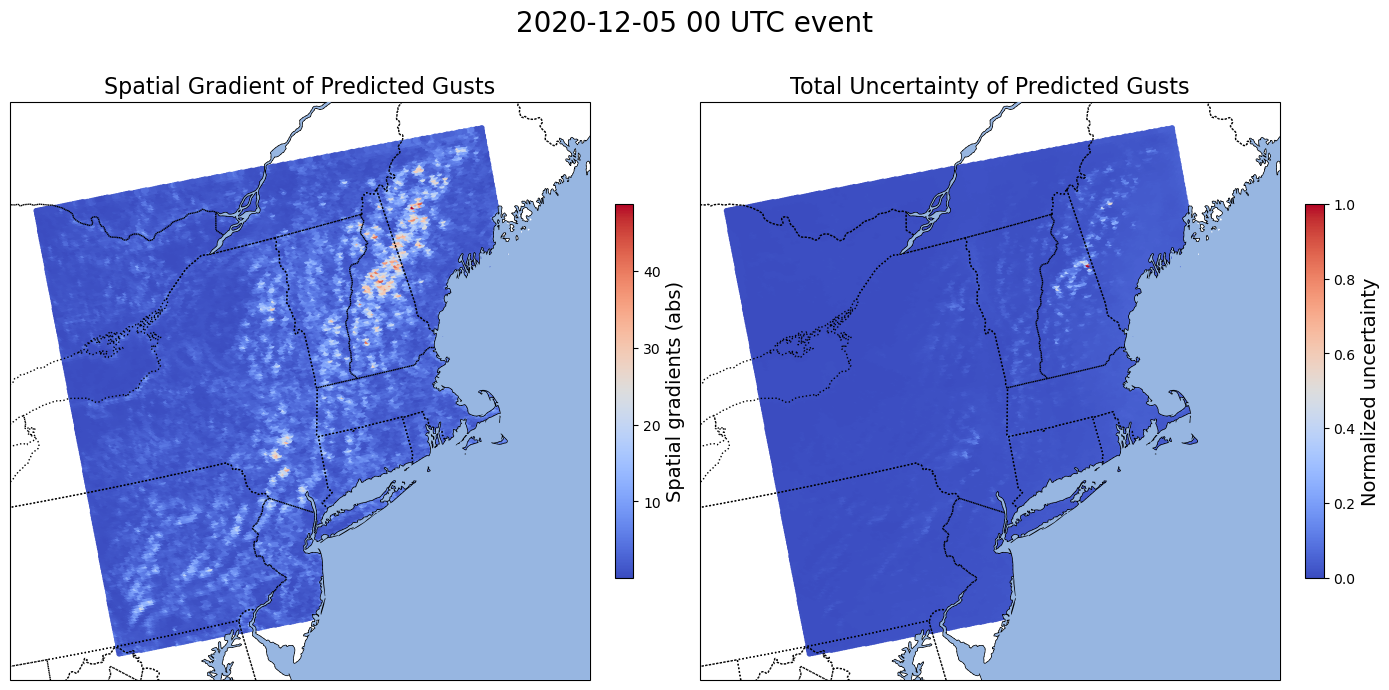

In [30]:
# Create figure with 2 panels (subplots)
# I want the resultiong map to have Lambert Corformal Conic projection 
fig, axes = plt.subplots(1, 2, figsize=(14, 8), subplot_kw={'projection': ccrs.LambertConformal()})

# Set up map features
for ax in axes:
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.OCEAN,zorder=10)
    #ax.add_feature(cfeature.OCEAN)

# Panel 1: Plot the Predictions
scatter1 = axes[0].scatter(
    data['Lon'],
    data['Lat'],
    c=data['Gradient_Predictions'],
    cmap='coolwarm',  # Adjust colormap as needed
    transform=ccrs.PlateCarree(),
    s=10
)

# Panel 2: Plot the Uncertainty
scatter2 = axes[1].scatter(
    data['Lon'],
    data['Lat'],
    c=data['Total_norm'],
    cmap='coolwarm',  # Adjust colormap as needed
    transform=ccrs.PlateCarree(),
    s=10
)

# Add colorbars for both panels
cbar1 = plt.colorbar(scatter1, ax=axes[0], orientation="vertical", fraction=0.03, pad=0.04)
cbar1.set_label("Spatial gradients (abs)", fontsize=14)

cbar2 = plt.colorbar(scatter2, ax=axes[1], orientation="vertical", fraction=0.03, pad=0.04)
cbar2.set_label("Normalized uncertainty", fontsize=14)

# Titles and Labels
axes[0].set_title("Spatial Gradient of Predicted Gusts", fontsize=16)
axes[1].set_title("Total Uncertainty of Predicted Gusts", fontsize=16)

axes[0].set_xlabel("Longitude", fontsize=15)
axes[0].set_ylabel("Latitude", fontsize=15)

axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("Latitude", fontsize=12)

# Adjust layout
fig.suptitle('2020-12-05 00 UTC event', fontsize=20,y=0.95)
plt.tight_layout()
plt.savefig('sp_grd_ocean_masked_2020_12_05_00.png',dpi=300)
plt.show()

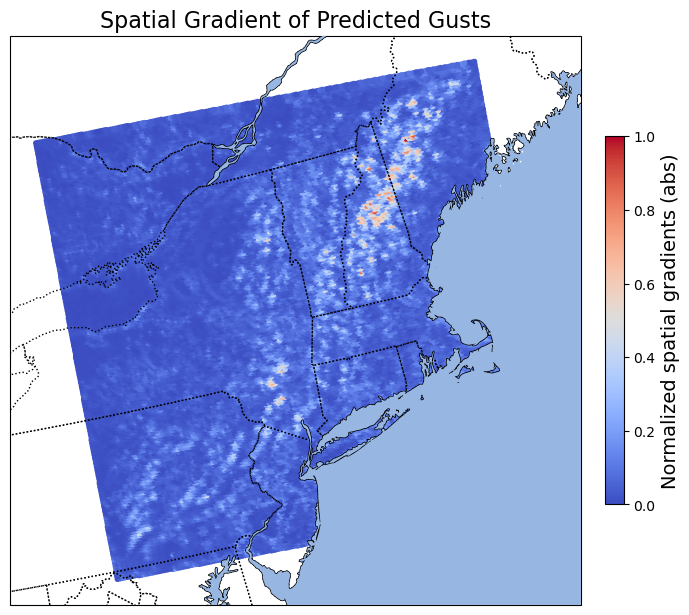

In [9]:
# Create figure with 2 panels (subplots)
# I want the resultiong map to have Lambert Corformal Conic projection 
fig, ax = plt.subplots(1, 1, figsize=(7, 8), subplot_kw={'projection': ccrs.LambertConformal()})

# Set up map features

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=1)
ax.add_feature(cfeature.OCEAN,zorder=10)
#ax.add_feature(cfeature.OCEAN)

# Panel 1: Plot the Predictions
scatter1 = ax.scatter(
    data['Lon'],
    data['Lat'],
    c=data['Grad_pred_norm'],
    cmap='coolwarm',  # Adjust colormap as needed
    transform=ccrs.PlateCarree(),
    s=10
)


# Add colorbars for both panels
cbar1 = plt.colorbar(scatter1, orientation="vertical", fraction=0.03, pad=0.04)
cbar1.set_label("Normalized spatial gradients (abs)", fontsize=14)


# Titles and Labels
ax.set_title("Spatial Gradient of Predicted Gusts", fontsize=16)

ax.set_xlabel("Longitude", fontsize=15)
ax.set_ylabel("Latitude", fontsize=15)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Adjust layout
#fig.suptitle('2020-04-09 12 UTC event', fontsize=20,y=0.95)
plt.tight_layout()
plt.savefig('new_sp_grd_ocean_masked_2020_12_05_00.png',dpi=300)
plt.show()

In [10]:
# import pandas as pd
# from scipy.spatial import cKDTree
# import numpy as np

In [11]:
# # Load the data
# data = pd.read_csv('Avg_values.csv')

# # Extract relevant columns for nearest neighbor search
# coords = data[['Lat', 'Lon']].values
# tree = cKDTree(coords)

In [12]:
# tree

In [13]:
# coords

In [14]:
# current_coord = np.array([data.loc[0,'Lat'],data.loc[0,'Lon']])

In [15]:
# current_coord

In [16]:
# distances, indices = tree.query(current_coord, k=5)

In [17]:
# distances

In [18]:
# indices

In [19]:
# neighbors = data.iloc[indices[1:]]

In [20]:
# neighbors

In [21]:
# neighbor_coords = neighbors[['Lat', 'Lon']].values

In [22]:
# neighbor_coords

In [23]:
# neighbor_values = neighbors['Predictions'].values

In [24]:
# neighbor_values

In [25]:
#gradients = (neighbor_values - data.loc[0,'Predictions']) / np.linalg.norm(neighbor_coords - current_coord, axis=1)

In [26]:
# gradients 

In [27]:
# neighbor_values - data.loc[0,'Predictions']

In [28]:
# np.linalg.norm(neighbor_coords - current_coord, axis=1)

In [29]:
# data